# 🧭 Contextual Factors in Horse Racing Performance

This notebook explores **contextual variables** — information known **before** a race takes place — to understand how they relate to race outcomes.

These variables don’t involve the horse’s talent, price, or connections. Instead, they describe the **environment of the race**: the setup, conditions, and structure that all runners must navigate.

Understanding these factors is essential for:
- Framing the problem space
- Building predictive models
- Identifying structural biases (e.g. track bias, draw bias)
- Separating skill from circumstance

---

## 📌 What We Explore in This Notebook

| Variable   | Description                                     |
|------------|-------------------------------------------------|
| `draw`     | Stall position — does lower draw provide an edge? |
| `ran`      | Field size — how does number of runners affect win rate? |
| `going`    | Ground condition — do some goings favour winners more than others? |
| `class`    | Race grade — is it harder to win in higher-class races? |
| `course`   | Racecourse — do some tracks have systematically higher or lower win rates? |

---

Each section includes:
- A brief explanation of the variable
- A visualisation of how it relates to win rate
- A short analysis highlighting trends or irregularities

This forms the foundation for more advanced modelling later on, helping us distinguish between **contextual variance** and **true performance**.



In [13]:
import pandas as pd
flat_df = pd.read_feather("../db/data_flat_uk_ire.feather")


print(flat_df.shape)

(473928, 41)


## 🏇 Win Rate by Stall Draw (Flat Races Only)

In Flat racing, horses are assigned a **stall (draw) number**, which determines their position at the start of the race — typically from inside rail (low numbers) to outer edge (high numbers).

This variable is set **in advance of the race** and can have a significant impact on a horse’s chances, especially on tighter tracks or in sprints.

In this section, we examine how **win rate varies by stall draw**, using the full Flat race dataset. Each point on the chart shows the percentage of runners who won from that specific draw number.


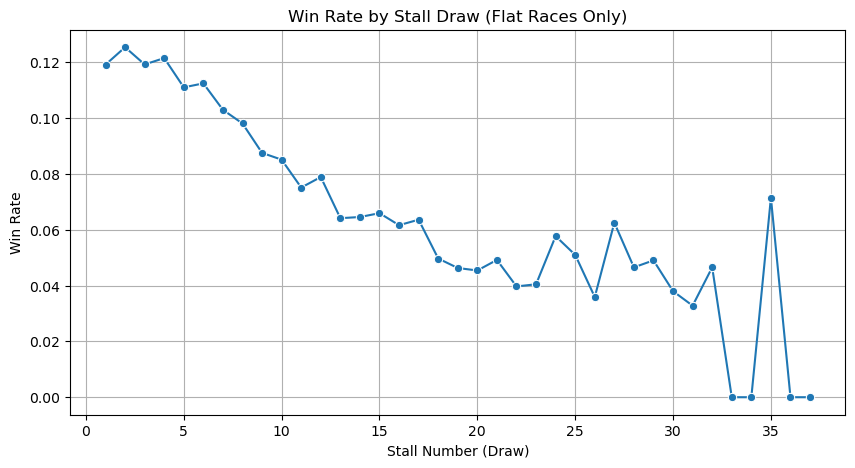

In [14]:
# Filter to rows with valid draw numbers and flat races
flat_draw_df = flat_df[flat_df['draw'].notnull()].copy()
flat_draw_df['draw'] = flat_draw_df['draw'].astype(int)

# Group by draw and calculate win rate
draw_win_rate = (
    flat_draw_df.groupby('draw')['won']
    .mean()
    .reset_index()
    .rename(columns={'won': 'win_rate'})
)

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='draw', y='win_rate', data=draw_win_rate, marker='o')
plt.title('Win Rate by Stall Draw (Flat Races Only)')
plt.xlabel('Stall Number (Draw)')
plt.ylabel('Win Rate')
plt.grid(True)
plt.show()


## 🏇 Win Rate by Stall Draw (UK & IRE – Flat Races Only)

This chart shows how a horse’s **starting stall position (draw)** affects its chances of winning in UK and Irish Flat races.

Each point represents the **win rate** for runners drawn in that specific stall number, across all distances, classes, and courses.

---

### ✅ Key Observations:
- **Lower draw numbers (1–5)** consistently show the **highest win rates** — often above **12%**.
- Win rates **decline steadily** as draw increases, particularly from stall 8 onward.
- By **draw 20+**, win rates drop below 6% and remain low — though small sample sizes beyond 30 may introduce noise.
- This trend confirms a **strong inside draw bias**, which is well-known in UK Flat racing, particularly at tighter tracks and shorter distances.

---

### 📌 Why It Matters

Stall draw is a **contextual factor assigned before the race**. Understanding how it affects outcomes can:

- Inform pre-race expectations
- Help detect track-specific biases
- Be incorporated into predictive models


### 📌 Next Steps:
In future notebooks, we may:
- Explore draw bias by **course** and **race distance**
- Compare win rates against **market expectations** (e.g. starting price)
- Quantify draw bias as a feature in predictive models
- Investigate whether the **betting market adjusts correctly** for stall position

This sets the stage for richer context-aware modelling, similar to how the book transitions from raw play success to structured prediction models.


## 👥 Win Rate by Field Size (Number of Runners)

Field size — the number of runners in a race — has a direct influence on a horse's chance of winning.

Larger fields generally mean:
- **Tougher competition** — more rivals to beat
- **Greater in-race variance** — more chance of interference, congestion, or bad luck
- **Lower individual win probability** — only one winner, but more contenders

Smaller fields, on the other hand, often:
- Make it easier for the best horse to assert
- Lead to more tactical races, with fewer pace influences

In this section, we group runners by the total number of starters in their race (from the `ran` column) and calculate win rates across different field sizes. This helps us visualise how competitiveness affects performance at a basic level.



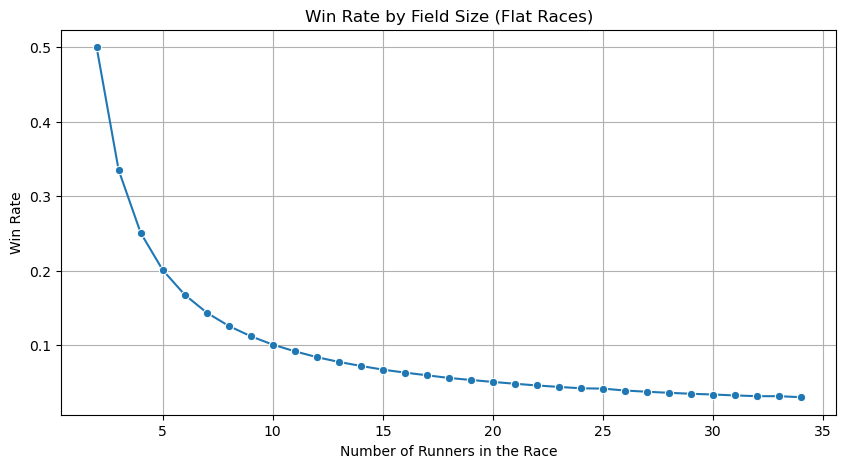

In [15]:
# Only keep rows where we know the number of runners
flat_field_df = flat_df[flat_df['ran'].notnull()].copy()

# Group by number of runners in the race
field_win_rate = (
    flat_field_df.groupby('ran')['won']
    .mean()
    .reset_index()
    .rename(columns={'ran': 'field_size', 'won': 'win_rate'})
)

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='field_size', y='win_rate', data=field_win_rate, marker='o')
plt.title('Win Rate by Field Size (Flat Races)')
plt.xlabel('Number of Runners in the Race')
plt.ylabel('Win Rate')
plt.grid(True)
plt.show()


### 📉 Key Observations: Win Rate by Field Size

- The win rate declines **smoothly and predictably** as the number of runners increases.
- This is consistent with basic logic: in a race with `N` runners, each horse has a 1-in-`N` chance of winning **if all things are equal**.
- For example:
  - In 2-runner races, win rate ≈ 50%
  - In 10-runner races, win rate ≈ 10%
  - In 20-runner races, win rate ≈ 5%
- The curve shows **no unexpected irregularities**, confirming that field size is a **natural limiter on win probability**.

### ⚠️ Edge Cases
- Races with **1 runner** will always show a 100% win rate — these are walkovers or voided races and can usually be excluded from modelling.
- There may be **noise at the extremes** (very small or very large fields), but the overall trend is clean.

### 🧠 Why This Matters
This relationship provides a **baseline expectation**. Any horse winning **more often than this baseline** — given their field size — may be performing above average. This also allows us to explore whether factors like **draw**, **going**, or **rating** matter **more** in certain field sizes.

We'll keep this in mind as we begin to combine features in later analysis.


## 🌱 Win Rate by Going (Track Condition – Split by Region & Surface)

The **going** (ground condition) is one of the most important contextual variables in horse racing — affecting pace, stamina, and race dynamics.

However, **terminology differs by country**, so we've standardised the values and separated the analysis by **region**.

---

### ✅ Standardised Going Types

#### 🇬🇧 United Kingdom (Turf)
- `Firm`
- `Good to Firm`
- `Good`
- `Good to Soft`
- `Soft`
- `Heavy`

These are the official UK going categories, ranging from dry and fast (`Firm`) to waterlogged (`Heavy`).

---

#### 🇮🇪 Ireland (Turf)
Ireland uses a slightly different scale with unique intermediates:

- `Firm`
- `Good to Firm`
- `Good`
- `Good to Yielding`
- `Yielding to Firm`
- `Yielding`
- `Yielding to Soft`
- `Soft`
- `Soft to Heavy`
- `Heavy`

The term **“Yielding”** is distinctive to Irish turf and represents ground softer than Good but not as deep as Soft.

---

#### 🟧 All-Weather (UK & IRE)
AW surfaces use a separate scale that typically includes:
- `Standard`
- `Standard to Slow`
- `Slow`
- `Fast`
- *(less common: `Muddy`, `Sloppy` — often legacy or imported terms)*

---

### 🧹 What We've Done
- Cleaned and recoded all `going` labels into a new `standard_going` column
- Created a `surface` column (`Turf`, `AW`, or `Unknown`)
- Assigned each race to a **region**: `UK`, `IRE`, `AW`, or `Unknown`

We now analyse win rate by **standardised going**, split by region.

In this section, we group runners in Flat races by the recorded going and calculate their win rates. This gives a first look at how going affects overall performance across the dataset, and whether any goings stand out as more or less competitive.


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Clean Going ---
def clean_going(going):
    if not isinstance(going, str):
        return 'Unknown'
    g = going.lower().strip()

    # UK goings
    if g == 'firm': return 'Firm'
    if g == 'good to firm': return 'Good to Firm'
    if g == 'good': return 'Good'
    if g == 'good to soft': return 'Good to Soft'
    if g == 'soft': return 'Soft'
    if g in ['heavy', 'soft to heavy']: return 'Heavy'

    # Ireland-specific
    if g == 'yielding': return 'Yielding'
    if g == 'yielding to soft': return 'Yielding to Soft'
    if g == 'yielding to firm': return 'Yielding to Firm'
    if g == 'good to yielding': return 'Good to Yielding'

    # AW
    if g in ['standard', 'standard to slow', 'slow', 'fast', 'muddy', 'sloppy']:
        return g.title()

    return 'Unknown'

# --- Surface Type ---
def get_surface(g):
    g = g.lower()
    if g in ['standard', 'standard to slow', 'slow', 'fast', 'muddy', 'sloppy']:
        return 'AW'
    if g in ['firm', 'good to firm', 'good', 'good to soft', 'soft', 'heavy',
             'yielding', 'yielding to soft', 'yielding to firm', 'good to yielding']:
        return 'Turf'
    return 'Unknown'

# --- Assign Region ---
def assign_region(row):
    course = row['course'].lower()
    surface = row['surface']

    if surface == 'AW':
        return 'AW'
    if '(ire)' in course:
        return 'IRE'
    if '(' not in course:
        return 'UK'
    return 'Unknown'

# Apply transformations
flat_df['standard_going'] = flat_df['going'].apply(clean_going)
flat_df['surface'] = flat_df['standard_going'].apply(get_surface)
flat_df['region'] = flat_df.apply(assign_region, axis=1)


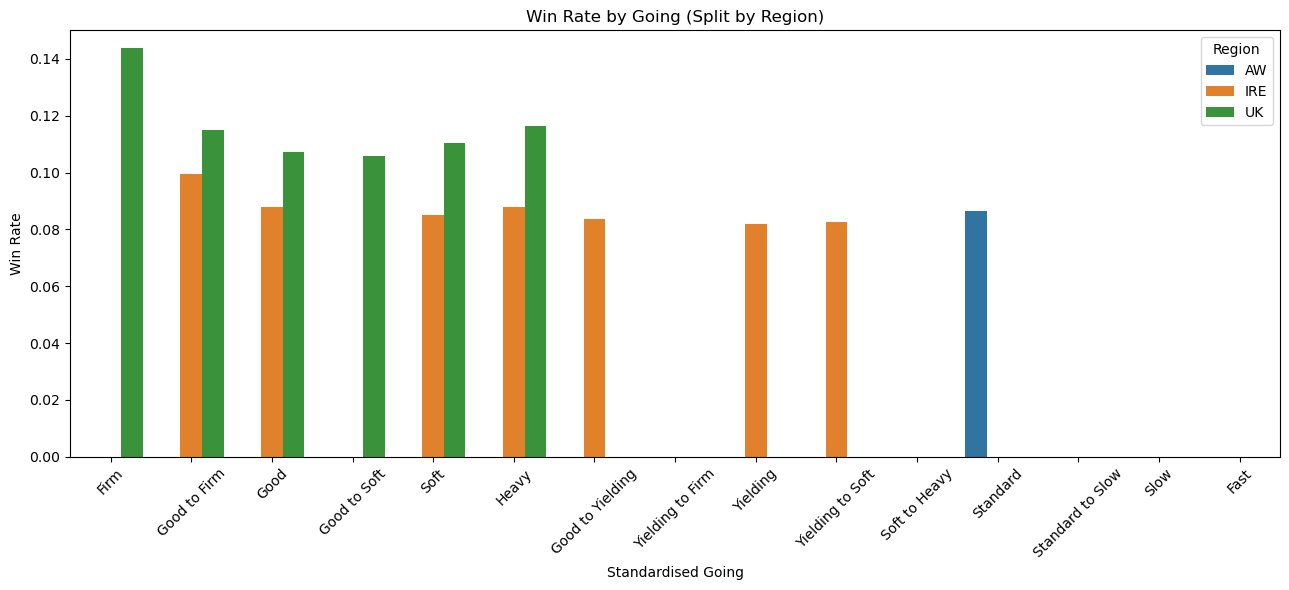

In [21]:
# Filter valid regions only
filtered = flat_df[flat_df['region'] != 'Unknown'].copy()

# Win rate by standardised going and region
going_summary = (
    filtered
    .groupby(['standard_going', 'region'], observed=True)['won']
    .mean()
    .reset_index()
    .rename(columns={'won': 'win_rate'})
)

# Order the goings for logical visual grouping
ordered_goings = [
    'Firm', 'Good to Firm', 'Good', 'Good to Soft', 'Soft', 'Heavy',
    'Good to Yielding', 'Yielding to Firm', 'Yielding', 'Yielding to Soft',
    'Soft to Heavy',
    'Standard', 'Standard to Slow', 'Slow', 'Fast'
]

going_summary['standard_going'] = pd.Categorical(
    going_summary['standard_going'],
    categories=ordered_goings,
    ordered=True
)

# Sort for nice plotting
going_summary = going_summary.sort_values(['region', 'standard_going'])

# Plot
plt.figure(figsize=(13, 6))
sns.barplot(data=going_summary, x='standard_going', y='win_rate', hue='region')
plt.title('Win Rate by Going (Split by Region)')
plt.ylabel('Win Rate')
plt.xlabel('Standardised Going')
plt.xticks(rotation=45)
plt.ylim(0, 0.15)
plt.tight_layout()
plt.legend(title='Region')
plt.show()


## 🧾 Conclusion: Win Rate by Going (Split by Region)

This chart compares win rates across different ground conditions (*goings*), separated by region:

- 🟩 **UK Turf:** Win rates are highest on faster surfaces like `Firm` and `Good to Firm`, gradually declining through to `Heavy`. These goings follow the **British Horseracing Authority (BHA)** scale.
- 🟧 **Ireland Turf:** Win rates appear more stable and slightly lower overall. Irish goings include `Yielding`, `Good to Yielding`, and `Yielding to Soft`. Notably, `Yielding to Firm` is **absent** — likely because it's rarely used in Ireland or gets recorded as `Good` or `Good to Firm` in practice.
- 🟦 **All-Weather (AW):** Only `Standard` is represented in this flat-race dataset. Other AW designations like `Slow`, `Standard to Slow`, or `Fast` **do exist** but are:
  - Rare in UK/IRE fixtures,
  - Specific to certain AW surfaces (e.g. Tapeta, Fibresand),
  - Infrequently used, or
  - Inconsistently recorded in historical data.

---

### 🔍 Key Takeaways:
- Going has **clear performance implications**, especially in the UK where firmer ground correlates with higher win rates.
- Splitting by **region** is essential to avoid comparing incompatible going scales.
- The absence of some goings reflects **real-world recording practices**, not data loss.

In future analyses, we may:
- Combine rare goings into broader categories (e.g. `Soft or worse`)
- Explore interaction effects (e.g. `Going × Distance`, `Going × Course`)
- Model going preference at the horse or trainer level


## 🎓 Win Rate by Race Class

Race class provides a rough measure of the quality and competitiveness of a race. In UK Flat racing, races are graded from **Class 1** (highest quality: Group and Listed races) to **Class 6** (lowest quality: low-grade handicaps and sellers).

Higher class means:
- Better horses
- More competition
- Smaller fields in some cases (due to entry restrictions)

In this section, we group Flat runners by race class and calculate win rate across each level. This helps us see whether class has a direct relationship with winning probability, and whether any levels stand out as being particularly favourable or difficult.


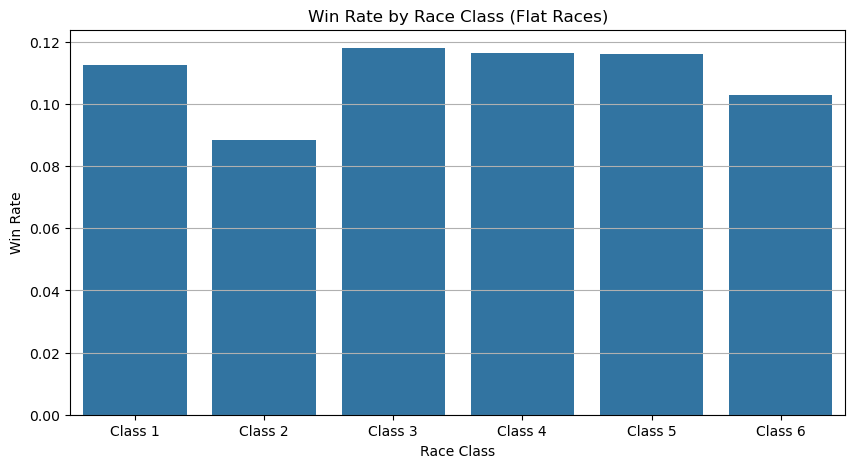

In [19]:
# Filter flat races with known class
flat_class_df = flat_df[flat_df['class'].notnull()].copy()

# Standardise class text and remove noise
flat_class_df['class'] = flat_class_df['class'].str.strip().str.title()

# Keep only UK-style "Class X" races
flat_class_df = flat_class_df[flat_class_df['class'].str.contains("Class", na=False)]

# Optional: order classes 1 (best) to 6 (lowest)
ordered_classes = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6']
flat_class_df['class'] = pd.Categorical(flat_class_df['class'], categories=ordered_classes, ordered=True)

# Group and calculate win rate
class_win_rate = (
    flat_class_df.groupby('class', observed=True)['won']
    .mean()
    .reset_index()
    .rename(columns={'won': 'win_rate'})
)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='class', y='win_rate', data=class_win_rate, order=ordered_classes)
plt.title('Win Rate by Race Class (Flat Races)')
plt.xlabel('Race Class')
plt.ylabel('Win Rate')
plt.grid(axis='y')
plt.show()


## 🏆 Win Rate by Race Class (Flat Races)

This chart shows the average win rate by **official race class** for flat races in the UK & Ireland. Race class generally reflects the **quality and prestige** of the race, with:

- **Class 1** being the highest level (Group/Listed races)
- **Class 6** being the lowest (low-grade handicaps or sellers)

### 🔍 Observations:
- Win rates are fairly consistent across classes, ranging from ~9% to ~12%.
- **Class 2** has the lowest win rate — possibly due to larger or more competitive fields.
- **Classes 3–5** show slightly higher win rates than both Class 1 and Class 6, which is somewhat unexpected and may warrant further investigation.
- **Class alone** does not appear to be a strong differentiator of win probability, at least at a population level.

### 🧠 Interpretation:
- Higher class races might attract **more evenly matched fields**, making it harder to dominate.
- Lower class races may have more **predictable outcomes** due to the presence of weaker runners.
- Useful in modelling when combined with other variables like **rating bands**, **field size**, or **official ratings (OR)**.

Further analysis could explore:
- How race class interacts with field size or rating
- Win rate by class over time or by trainer
- Whether betting value differs by class


## 🏇 Win Rate by Racecourse

Racecourses vary in layout, draw bias, ground management, and pace profiles — all of which can influence outcomes. Some courses favour front-runners, others suit hold-up horses; some are sharp and turning, others wide and galloping.

In this section, we calculate the win rate for runners at each course — focusing on the 30 courses with the most data — to get a high-level sense of:

- Which tracks produce the most consistent outcomes
- Whether any course stands out as unusually high or low for win rate
- Where future course-specific deep dives might be worth pursuing (e.g. draw bias at Chester)

This is not about judging course “fairness” yet — just mapping out the landscape.


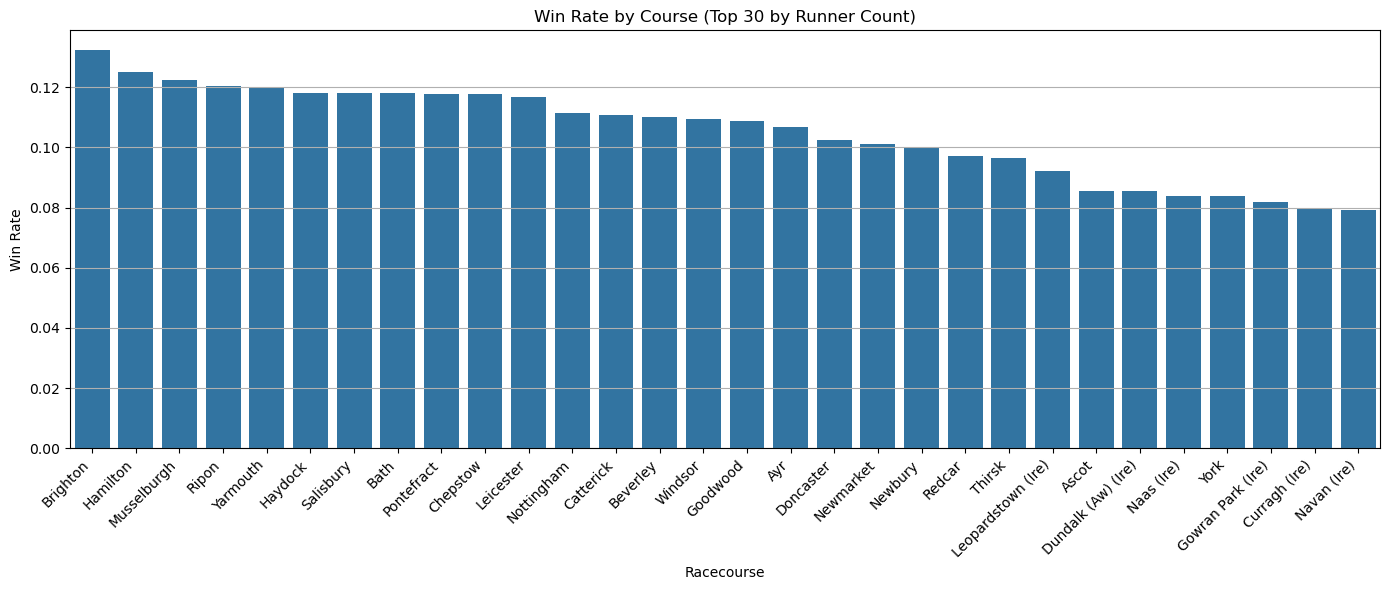

In [20]:
# Clean and group course names
flat_course_df = flat_df[flat_df['course'].notnull()].copy()
flat_course_df['course'] = flat_course_df['course'].str.strip().str.title()

# Get top 30 most common courses by number of runners
top_courses = (
    flat_course_df['course'].value_counts()
    .head(30)
    .index.tolist()
)

# Filter to top 30 courses
top_course_df = flat_course_df[flat_course_df['course'].isin(top_courses)]

# Group by course and calculate win rate
course_win_rate = (
    top_course_df.groupby('course', observed=True)['won']
    .mean()
    .reset_index()
    .rename(columns={'won': 'win_rate'})
    .sort_values('win_rate', ascending=False)
)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(x='course', y='win_rate', data=course_win_rate)
plt.title('Win Rate by Course (Top 30 by Runner Count)')
plt.xlabel('Racecourse')
plt.ylabel('Win Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## 🏟️ Win Rate by Racecourse (Flat Races – Top 30 by Runner Count)

This chart shows the average win rate by racecourse, based on the 30 most active tracks in our dataset (UK & IRE flat races only).

### 🔍 Observations:
- **Brighton, Hamilton, and Musselburgh** top the chart with win rates exceeding 12%.
- A gentle decline follows across mid-tier courses like **Bath, Leicester, and Beverley**.
- Courses with **lower average win rates** include major venues like **Ascot, York, and Curragh**, as well as **Irish tracks** such as **Navan** and **Gowran Park**.

### 🧠 Interpretation:
- Win rate here is a **proxy for field size and competitiveness**:
  - Tracks with higher win rates likely host **smaller, less competitive fields**.
  - Lower win rates likely reflect **larger or more competitive fields**, typical of elite venues.
- **Course layout and bias** may also play a role — e.g., Brighton is known for being tricky due to its undulations and tight turns.

### ⚠️ Notes:
- This doesn’t reflect **horse ability** or betting value — just the likelihood of any horse winning at a given course.
- To dive deeper, we could:
  - Break this down by **race class or distance**
  - Explore **field size distribution** by course
  - Analyse **draw bias or surface type**


